In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import pytorch_lightning as pl
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torchvision import transforms, datasets
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [91]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 32
data_folder = "~/datasets/CIFAR10"

trainset = torchvision.datasets.CIFAR10(root=data_folder, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_folder, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = trainset.classes

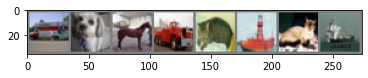

truck   dog horse truck   cat  ship   cat  ship


In [55]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(8)))

In [109]:
# net = nn.Sequential(
#     nn.LazyConv2d(64, 5),
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2),
#     nn.LazyConv2d(128, 3),
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2),
#     nn.LazyConv2d(256, 3),
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2),
#     Rearrange("b c h w -> b (c h w)"),
#     nn.LazyLinear(1024),
#     nn.ReLU(),
#     nn.LazyLinear(256),
#     nn.ReLU(),
#     nn.LazyLinear(10),
# )

class TorchTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=8, embed_dim=512, 
                 num_heads=8, num_layers=6, num_classes=10, 
                 drop_rate=0.1):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(img_size, patch_size, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, num_heads, dropout=drop_rate, 
                                                   activation='gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.classifier = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.transformer(x)
        x = self.norm(x)
        # maybe insert norm here
        x = self.classifier(x[:, 0])
        return x

net = TorchTransformer()
net.to(device)

TorchTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableL

In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [111]:
test_acc = []

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_acc.append(100 * correct / total)
    print(f'Epoch {epoch}\t Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

print('Finished Training')

[1,   200] loss: 0.206
[1,   400] loss: 0.194
[1,   600] loss: 0.190
[1,   800] loss: 0.183
[1,  1000] loss: 0.181
[1,  1200] loss: 0.177
[1,  1400] loss: 0.176
Epoch 0	 Accuracy of the network on the 10000 test images: 37 %
[2,   200] loss: 0.168
[2,   400] loss: 0.169
[2,   600] loss: 0.165
[2,   800] loss: 0.164
[2,  1000] loss: 0.164
[2,  1200] loss: 0.163
[2,  1400] loss: 0.159
Epoch 1	 Accuracy of the network on the 10000 test images: 42 %
[3,   200] loss: 0.154
[3,   400] loss: 0.154
[3,   600] loss: 0.154
[3,   800] loss: 0.151
[3,  1000] loss: 0.151
[3,  1200] loss: 0.149
[3,  1400] loss: 0.148
Epoch 2	 Accuracy of the network on the 10000 test images: 46 %
[4,   200] loss: 0.141
[4,   400] loss: 0.143
[4,   600] loss: 0.142
[4,   800] loss: 0.139
[4,  1000] loss: 0.140
[4,  1200] loss: 0.140
[4,  1400] loss: 0.138
Epoch 3	 Accuracy of the network on the 10000 test images: 47 %
[5,   200] loss: 0.134
[5,   400] loss: 0.133
[5,   600] loss: 0.134
[5,   800] loss: 0.134
[5,  100

[36,  1200] loss: 0.016
[36,  1400] loss: 0.016
Epoch 35	 Accuracy of the network on the 10000 test images: 61 %
[37,   200] loss: 0.013
[37,   400] loss: 0.012
[37,   600] loss: 0.014
[37,   800] loss: 0.016
[37,  1000] loss: 0.016
[37,  1200] loss: 0.016
[37,  1400] loss: 0.014
Epoch 36	 Accuracy of the network on the 10000 test images: 61 %
[38,   200] loss: 0.013
[38,   400] loss: 0.013
[38,   600] loss: 0.014
[38,   800] loss: 0.014
[38,  1000] loss: 0.014
[38,  1200] loss: 0.013
[38,  1400] loss: 0.016
Epoch 37	 Accuracy of the network on the 10000 test images: 61 %
[39,   200] loss: 0.011
[39,   400] loss: 0.012
[39,   600] loss: 0.014
[39,   800] loss: 0.012
[39,  1000] loss: 0.013
[39,  1200] loss: 0.014
[39,  1400] loss: 0.016
Epoch 38	 Accuracy of the network on the 10000 test images: 61 %
[40,   200] loss: 0.010
[40,   400] loss: 0.011
[40,   600] loss: 0.010
[40,   800] loss: 0.012
[40,  1000] loss: 0.012
[40,  1200] loss: 0.012
[40,  1400] loss: 0.012
Epoch 39	 Accuracy o

In [43]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class airplane is: 77.8 %
Accuracy for class automobile is: 85.2 %
Accuracy for class bird  is: 69.8 %
Accuracy for class cat   is: 52.1 %
Accuracy for class deer  is: 74.8 %
Accuracy for class dog   is: 67.5 %
Accuracy for class frog  is: 80.2 %
Accuracy for class horse is: 75.0 %
Accuracy for class ship  is: 83.2 %
Accuracy for class truck is: 81.2 %


In [42]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 74 %


## ViT

### PyTorch transformer layer

In [79]:
encoder_layer = nn.TransformerEncoderLayer(512, 8, activation='gelu')
net = nn.Sequential(
    PatchEmbed(img_size=32, patch_size=8, embed_dim=512),
    nn.TransformerEncoder(encoder_layer, 6),
    nn.Linear(512, 10),
)

In [80]:
net(images)

tensor([[[ 4.1617e-01,  3.9982e-01,  1.2600e-01,  ..., -4.5802e-01,
          -3.3091e-01,  6.8654e-01],
         [ 2.4491e-01, -5.5424e-02, -8.8039e-02,  ..., -6.2316e-01,
          -3.2469e-01,  7.0556e-01],
         [ 3.4414e-01, -3.4280e-01,  1.1338e-01,  ..., -9.5840e-01,
           2.0983e-01,  1.1120e+00],
         ...,
         [-4.4272e-01,  9.8886e-01,  6.4270e-02,  ...,  6.8520e-01,
          -5.5693e-01, -3.9169e-01],
         [-6.6131e-02,  6.8598e-01,  5.7281e-01,  ...,  3.9021e-01,
          -7.4485e-01, -2.3743e-01],
         [-9.9447e-02,  7.5286e-01,  4.1983e-01,  ...,  4.8694e-01,
          -6.7457e-01, -5.4904e-01]],

        [[ 3.4716e-01,  4.9240e-01,  3.8271e-01,  ..., -1.5311e-01,
           2.8414e-01,  4.1890e-01],
         [ 4.8921e-01, -1.5585e-01,  2.9613e-01,  ..., -8.2275e-01,
          -3.1350e-01,  7.6295e-02],
         [ 6.8373e-01, -4.2024e-01, -2.2619e-01,  ..., -1.1394e-01,
          -5.7316e-01,  4.3660e-01],
         ...,
         [-4.8353e-01,  1

In [77]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)
    
    
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
    
def to_2tuple(size):
    return (size, size)
    
    
class PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, norm_layer=None, flatten=True):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        if self.flatten:
            x = rearrange(x, "b c h w -> b (h w) c")
        x = self.norm(x)
        return x

In [74]:
patch_embed = PatchEmbed(img_size=32, patch_size=8, embed_dim=512)
patches = patch_embed(images[0].unsqueeze(0))

True


In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
    
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    """ Vision Transformer
    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`
        - https://arxiv.org/abs/2010.11929
    Includes distillation token & head support for `DeiT: Data-efficient Image Transformers`
        - https://arxiv.org/abs/2012.12877
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None, weight_init=''):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
            weight_init: (str): weight init scheme
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate,
                attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        self.init_weights(weight_init)

    def init_weights(self, mode=''):
        assert mode in ('jax', 'jax_nlhb', 'nlhb', '')
        head_bias = -math.log(self.num_classes) if 'nlhb' in mode else 0.
        trunc_normal_(self.pos_embed, std=.02)
        if self.dist_token is not None:
            trunc_normal_(self.dist_token, std=.02)
        if mode.startswith('jax'):
            # leave cls token as zeros to match jax impl
            named_apply(partial(_init_vit_weights, head_bias=head_bias, jax_impl=True), self)
        else:
            trunc_normal_(self.cls_token, std=.02)
            self.apply(_init_vit_weights)

    def _init_weights(self, m):
        # this fn left here for compat with downstream users
        _init_vit_weights(m)

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=''):
        _load_weights(self, checkpoint_path, prefix)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'dist_token'}

    def get_classifier(self):
        if self.dist_token is None:
            return self.head
        else:
            return self.head, self.head_dist

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        if self.num_tokens == 2:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])  # x must be a tuple
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x


def _init_vit_weights(module: nn.Module, name: str = '', head_bias: float = 0., jax_impl: bool = False):
    """ ViT weight initialization
    * When called without n, head_bias, jax_impl args it will behave exactly the same
      as my original init for compatibility with prev hparam / downstream use cases (ie DeiT).
    * When called w/ valid n (module name) and jax_impl=True, will (hopefully) match JAX impl
    """
    if isinstance(module, nn.Linear):
        if name.startswith('head'):
            nn.init.zeros_(module.weight)
            nn.init.constant_(module.bias, head_bias)
        elif name.startswith('pre_logits'):
            lecun_normal_(module.weight)
            nn.init.zeros_(module.bias)
        else:
            if jax_impl:
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    if 'mlp' in name:
                        nn.init.normal_(module.bias, std=1e-6)
                    else:
                        nn.init.zeros_(module.bias)
            else:
                trunc_normal_(module.weight, std=.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    elif jax_impl and isinstance(module, nn.Conv2d):
        # NOTE conv was left to pytorch default in my original init
        lecun_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.LayerNorm, nn.GroupNorm, nn.BatchNorm2d)):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)